In [2]:
import pandas as pd
import numpy as np
from libs.utils import fix_continent_matches, cumsum_graph, format_dataframe, get_continent_from_fifa, check_records_validity
from matplotlib import pyplot as plt
from matplotlib.collections import LineCollection
import matplotlib.colors as mcolors
from os import path
from scipy.stats import spearmanr, pearsonr, kendalltau
import seaborn as sns
from statsmodels.formula.api import ols
from sklearn import preprocessing, linear_model

plt.style.use('ggplot')
plt.rcParams.update({'figure.figsize':(45,10), 'figure.dpi':100})

PATH_ORIGINAL_DST = 'dataset/original'
PATH_DST = 'dataset'

## Parte 1: Introduzione dataset, verifica e preparazione

Si prende in analisi un dataset contenente 4483 risultati di partite di calcio internazionale maschile.<br>
L'obbiettivo è realizzare un predittore di risultati di partite di calcio internazionale [... aggiungi descrizione dal dataset stesso...]. Inizialmente viene preso in esame il dataset, vengono estratte alcune informazioni utilizzando la statistica descrittiva.<br>
Per prima cosa verifico l'eventuale presenza di valori nulli del dataset

In [2]:
df = pd.read_csv(path.join(PATH_ORIGINAL_DST ,'results.csv') );

print("Null values:", df.isnull().values.any(), "| shape:", df.shape)
print("***"*15)
print(df.info())

Null values: False | shape: (42483, 9)
*********************************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42483 entries, 0 to 42482
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   date        42483 non-null  object
 1   home_team   42483 non-null  object
 2   away_team   42483 non-null  object
 3   home_score  42483 non-null  int64 
 4   away_score  42483 non-null  int64 
 5   tournament  42483 non-null  object
 6   city        42483 non-null  object
 7   country     42483 non-null  object
 8   neutral     42483 non-null  bool  
dtypes: bool(1), int64(2), object(6)
memory usage: 2.6+ MB
None


### Pre-processing -- DONE
Dopo essermi accertato che il dataset non contiene elementi nulli procedo con il pre-processing:
- Estraggo la data dalla colonna `date` in rispettivamente in `day` `day_of_week` `month` `year`:
- Calcolo `outcome` dall'incontro utilizzando la funzione `return_outcome` che ritorna `Home` per vittoria della squadra di casa, `Draw` per il pareggio e `Away` per vittoria della squadra ospite
- Converto il valore `home_score` e `away_score` in `float` (servirà successivamente)
- Alcuni nomi di nazioni sono cambiate nel tempo, in quanto il dataset presenta incontri che comprendono ad ese
- Formatto i nomi delle nazioni [scrivi meglio]

In [3]:
df = format_dataframe(df)

Solitamente, nel calcio, la prima squadra è considerata sempre quella di casa. Controllo dunque che il dataset sia coerente con questa convenzione prima di procedere al calcolo delle statistiche per ogni team

In [4]:
if len(df.query("away_team == country")) > 0:
    print("Trovati %d record incorenti con la convenzione" % len(df.query("away_team == country")))

Trovati 25 record incorenti con la convenzione


Visto l'esiguo numero di elementi li visualizzo

In [5]:
df.query("away_team == country")

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral,outcome,year
788,1924-03-13,Catalonia,Spain,0.0,7.0,Friendly,Barcelona,Spain,False,Away,1924
1618,1933-10-04,Silesia,Poland,1.0,2.0,Friendly,Katowice,Poland,False,Away,1933
1650,1934-02-02,Catalonia,Spain,0.0,2.0,Friendly,Barcelona,Spain,False,Away,1934
2754,1947-10-19,Catalonia,Spain,3.0,1.0,Friendly,Barcelona,Spain,False,Home,1947
3487,1953-04-26,Silesia,Poland,2.0,3.0,Friendly,Chorzów,Poland,False,Away,1953
3526,1953-08-09,Catalonia,Spain,0.0,6.0,Friendly,Barcelona,Spain,False,Away,1953
3539,1953-09-13,Silesia,Poland,3.0,3.0,Friendly,Byton,Poland,False,Draw,1953
28848,2006-11-19,Crimea,Northern Cyprus,0.0,5.0,ELF Cup,Lefkoşa,Northern Cyprus,True,Away,2006
28898,2006-12-09,Silesia,Poland,1.0,1.0,Friendly,Chorzów,Poland,False,Draw,2006
31765,2009-10-28,South Africa,Zimbabwe,1.0,1.0,COSAFA Cup,Harare,Zimbabwe,True,Draw,2009


Sono state trovate dunque 25 incoerenze riguardo alla convenzione spiegata sopre. È semplice spiegarle:
- I record che presentano neutral = False: è spiegato dal fatto che la Silesia è oggi parte della Polonia e della Republica Ceca, mentre la Catalonia ad oggi è annessa alla Spagna. Questo sta a dimostrare che sono presenti  dati 'spuri' dal dataset di cui è già stata prevista l'eliminazione in seguito,<br>
- I record che presentano neutral = True sono incoerenti<br>

Sistemo:

In [6]:
for i in df.query("away_team == country and neutral == True").index:
    df.at[i, "neutral"] = False

Controllo che la presenza di ulteriori incoerenze anche nel caso in cui `home_team` sia uguale a `contry` e `neutral` sia uguale a `True`

In [7]:
df.query("home_team == country and neutral == True")

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral,outcome,year
10966,1979-08-29,Fiji,Papua New Guinea,0.0,0.0,South Pacific Games,Suva,Fiji,True,Draw,1979
35360,2013-07-15,Bermuda,Falkland Islands,8.0,0.0,Island Games,Hamilton,Bermuda,True,Home,2013
40116,2018-09-09,St. Kitts and Nevis,Puerto Rico,1.0,0.0,CONCACAF Nations League qualification,Basseterre,St. Kitts and Nevis,True,Home,2018
40399,2018-11-18,St. Kitts and Nevis,Canada,0.0,1.0,CONCACAF Nations League qualification,Basseterre,St. Kitts and Nevis,True,Away,2018
40757,2019-06-07,China PR,Philippines,2.0,0.0,Friendly,Guangzhou,China PR,True,Home,2019
41044,2019-08-11,St. Vincent / Grenadines,Trinidad and Tobago,1.0,0.0,Friendly,Georgetown,St. Vincent / Grenadines,True,Home,2019
41046,2019-08-27,St. Kitts and Nevis,Antigua and Barbuda,4.0,3.0,Friendly,Basseterre,St. Kitts and Nevis,True,Home,2019
41110,2019-09-06,USA,Mexico,0.0,3.0,Friendly,East Rutherford,USA,True,Away,2019
41229,2019-09-18,Congo DR,Rwanda,2.0,3.0,Friendly,Kinshasa,Congo DR,True,Away,2019
42068,2021-03-29,Congo DR,Gambia,1.0,0.0,African Cup of Nations qualification,Kinshasa,Congo DR,True,Home,2021


In [8]:
for i in df.query("home_team == country and neutral == True").index:
    df.at[i, "neutral"] = False

In [9]:
df.to_csv(path.join(PATH_DST, 'dataset_v1.csv'))

### Check validità match

Controllo la presenza di eventuali record ambigui, data anche la presenza di partite vecchie, ad esempio di nazioni non più presenti... spiega meglio ... non li considero da subito.

Per validare le squadre utilizzerò il dataset FIFA ...descrivi....

In [10]:
len(df)

42483

In [13]:
df_fifa = pd.read_csv(path.join(PATH_ORIGINAL_DST, 'fifa_ranking-2021-05-27.csv'))

df = check_records_validity(df, df_fifa)

df_valid = df.query("is_valid == True").drop(columns=['is_valid']).reset_index(drop=True)
df_valid.to_csv(path.join(PATH_DST, "dataset_v1_valid.csv"))
df_not_valid = df.query("is_valid == False").drop(columns=['is_valid']).reset_index(drop=True)
df_not_valid.to_csv(path.join(PATH_DST, "dataset_v1_not_valid.csv"))

if len(df_valid) + len(df_not_valid) == len(df):
    print("valid: %s not valid: %s, totale di record esaminati %s" % ( len(df_valid),len(df_not_valid), len(df) ) )
else:
    print("Something wrong happened!")

Valid country: 216
valid: 41685 not valid: 798, totale di record esaminati 42483


### Check validità nazioni

Dovrebbe servire per dopo nello specifico ma dato che questa è la parte dove pulisco il dataset lo faccio qui...

In [21]:
df_valid_country = pd.read_csv(path.join(PATH_DST, 'dataset_v1_valid.csv')).drop(columns=['Unnamed: 0'])

df_fifa = pd.read_csv(path.join(PATH_ORIGINAL_DST, 'fifa_ranking-2021-05-27.csv')).drop(columns=['id','rank', 'country_abrv', 'total_points', 'previous_points', 'rank_change', 'rank_date']).sort_values(by='country_full').drop_duplicates().reset_index(drop=True)

df_unvalid_country = pd.DataFrame()

# estraggo tutti i team presenti in dataset_reduced_fixed
df_ht = df_valid_country['home_team'].drop_duplicates().sort_values().reset_index().drop(labels=['index'], axis=1).rename(columns={'home_team': 'team'})
df_at = df_valid_country['away_team'].drop_duplicates().sort_values().reset_index().drop(labels=['index'], axis=1).rename(columns={'away_team': 'team'})

# controllo che il numero di squadre sia lo stesso
if df_ht.__len__() != df_at.__len__():
    print("Not same length! Some mismatch")
else:
    df_valid_country = pd.concat([df_ht,df_at]).drop_duplicates().sort_values(by='team').reset_index().drop(labels=['index'], axis=1)

    df_valid_country['confederation'] = ""

    for i, row in df_valid_country.iterrows():
        if(len(df_fifa.query("country_full == @row.team")) > 0):
            df_valid_country.at[i, 'confederation'] = df_fifa.query("country_full == @row.team").confederation.values[0]

    df_valid_country.replace("", np.nan, inplace=True)

    df_unvalid_country = df_valid_country[df_valid_country['confederation'].isna()]
    df_unvalid_country.reset_index(drop=True, inplace=True)
    df_unvalid_country.drop(labels=['confederation'], axis=1, inplace=True)

    # utilizzo le squadre non presenti in FIFA ranking
    df_valid_country.dropna(subset = ['confederation'], inplace=True)
    df_valid_country.reset_index(drop=True, inplace=True)

    print("... Fixed. Number of teams: %d" % len(df_valid_country))

    # salvo i dataframe perché potrebbero servire successivamente
    df_valid_country.to_csv(path.join(PATH_DST, 'dataset_v1_valid_country.csv'))
    df_unvalid_country.to_csv(path.join(PATH_DST, 'dataset_v1_not_valid_country.csv'))

... Fixed. Number of teams: 209


/Users/danilo/GitHub/fad-2020-2021/venv/lib/python3.8/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


Procedo con eliminare tutte quei match che presentano squadre in 'df_unvalid_countries_csv' e realizzo la seconda versione del dataset

In [20]:
# per evitare problemi riguardo le variabili reimporto i csv
df = pd.read_csv(path.join(PATH_DST, 'dataset_v1_valid.csv')).drop(columns=['Unnamed: 0'])

for index, row in df_unvalid_country.iterrows():
    if(len(df.query("home_team == @row.team or away_team == @row.team")) > 0):
        df.drop(df.query("home_team == @row.team or away_team == @row.team").index.values, inplace=True)
    

print("Now dataset is formed by: %d records"% len(df))

Now dataset is formed by: 39029 records


Controllo che il numero di squadre che ha giocato fuori casa è lo stesso di chi ha giocato in casa ed eventualmente visualizzo

In [46]:
if len(df['home_team'].drop_duplicates().sort_values().values) > len(df['away_team'].drop_duplicates().sort_values().values):
    print("Mismatch home_team > away_team: %s" % list(set(df['home_team'].drop_duplicates().sort_values().values).difference(df['away_team'].drop_duplicates().sort_values().values)))
elif len(df['home_team'].drop_duplicates().sort_values().values) < len(df['away_team'].drop_duplicates().sort_values().values):
    print("Mismatch home_team < away_team: %s" % list(set(df['away_team'].drop_duplicates().sort_values().values).difference(df['home_team'].drop_duplicates().sort_values().values)))
else:
    print("Home teams and away teams are the same")

Mismatch home_team > away_team: ['St. Kitts and Nevis']


.... inserisci perché magari filtra il dst .....

In [56]:
print("Deleting %s records from dataset..."% len(df[df.home_team == "St. Kitts and Nevis"].index) )
df.drop(df[df.home_team == "St. Kitts and Nevis"].index, inplace=True)
print("Now dataset is formed by: %d records"% len(df))
df.to_csv(path.join(PATH_DST, "dataset_v2.csv"))


Deleting 91 records from dataset...
Now dataset is formed by: 38938 records


## Parte 2: Statistica descrittiva - Distribuzione dei dati
Una volta effettuato il preprocessing del dataset vengono applicati alcuni studi. In ordine verrà definito, graficamente:
- Competizioni presenti nel dataset
- Numero di partite disputate per anno
- Numero di partite disputate per anno in base al continente (in modo tale da capire anche una eventuale inizio della diffusione del calcio nel mondo)
- Numero di goal per anno, divise in base al continente

Dopo aver estrapolato queste informazioni, si procede con una selezione dei migliori team durante la storia divisi per attacco/difesa goal fatti/subiti.<br>
Da questi insiemi verranno estratti una gruppo di squadre per mostrare l'andamento della squadra negli anni.<br>
Inoltre verrà controllato se questo insieme di squadre hanno più propensione di vincere a casa o in trasferta.<br>

<b>Per questo 'capitolo' pendo come riferimento il dataset v2'</b>

In [24]:
df = pd.read_csv(path.join(PATH_DST, 'dataset_v2.csv')).drop(columns=['Unnamed: 0'])

df.head(5)

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral,outcome,year
0,1872-11-30,Scotland,England,0.0,0.0,Friendly,Glasgow,Scotland,False,Draw,1872
1,1873-03-08,England,Scotland,4.0,2.0,Friendly,London,England,False,Home,1873
2,1874-03-07,Scotland,England,2.0,1.0,Friendly,Glasgow,Scotland,False,Home,1874
3,1875-03-06,England,Scotland,2.0,2.0,Friendly,London,England,False,Draw,1875
4,1876-03-04,Scotland,England,3.0,0.0,Friendly,Glasgow,Scotland,False,Home,1876


### Competizioni presenti nel dataset

Number of tournaments: 109


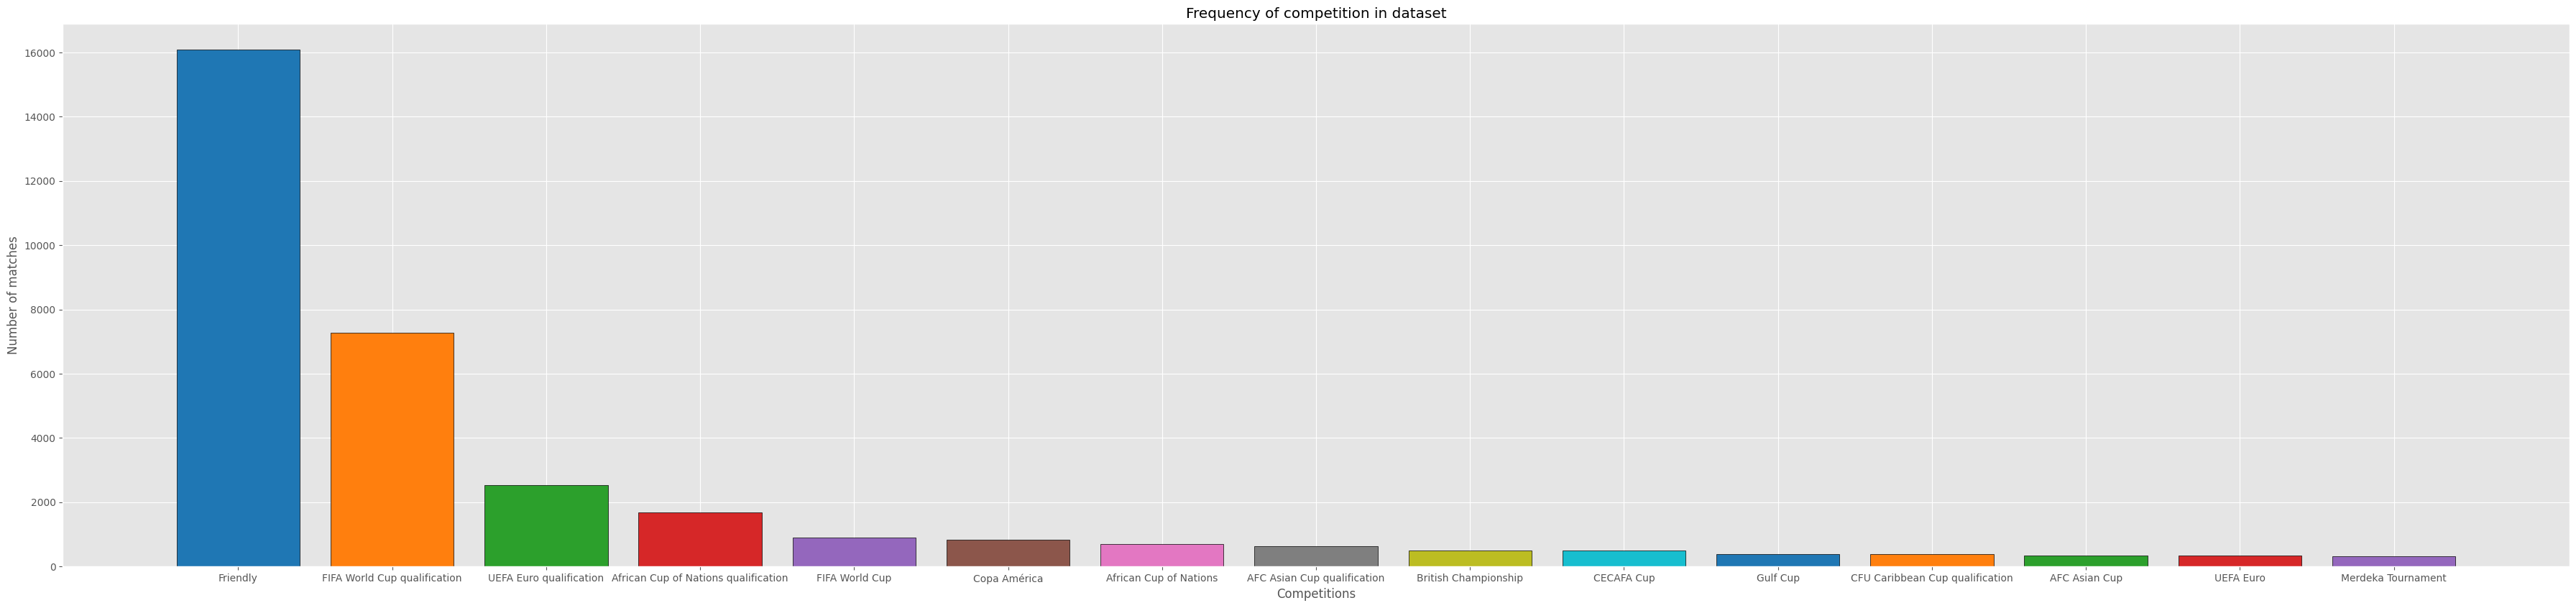

In [25]:
tournaments = df['tournament'].value_counts()

print("Number of tournaments: %d" % ( len(tournaments) ))

# Visto l'elevato numero di competizioni presenti, considero solo le prime 15 in base al numero di partite.

plt.title('Frequency of competition in dataset')
plt.ylabel('Number of matches')
plt.xlabel('Competitions')
plt.bar(tournaments.index[:15], tournaments.values[:15], color=[i for i in mcolors.TABLEAU_COLORS], edgecolor='black')

plt.show()

### Numero di partite disputate per anno

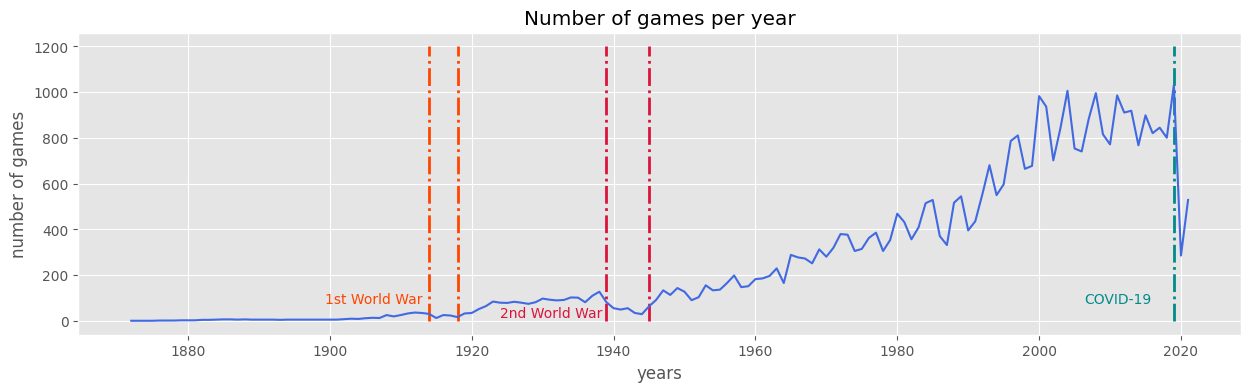

In [26]:
# matches per year
mpy = df['year'].value_counts().sort_index()

plt.figure(figsize=(15,4))
plt.title(label='Number of games per year')
plt.ylabel(ylabel='number of games')
plt.xlabel(xlabel='years')

l1 = [(1914,0), (1914,1200)]
l2 = [(1918,0), (1918,1200)]
l3 = [(1939,0), (1939,1200)]
l4 = [(1945,0), (1945,1200)]
l5 = [(2019,0), (2019, 1200)]

lc = LineCollection([l1, l2, l3, l4, l5], color=["orangered","orangered", "crimson","crimson", "darkcyan"], lw=2, linestyles='-.')

plt.annotate('1st World War', xy=(1914, 200), xycoords='data', ha='center', xytext=(-40, -20), textcoords='offset points', color='orangered')
plt.annotate('2nd World War', xy=(1939, 200), xycoords='data', ha='center', xytext=(-40, -30), textcoords='offset points', color='crimson')
plt.annotate('COVID-19', xy=(2019, 200), xycoords='data', ha='center', xytext=(-40, -20), textcoords='offset points', color='darkcyan')

plt.gca().add_collection(lc)

plt.plot(mpy, color='royalblue')
plt.grid(True)
plt.show()

Si nota che il numero di match si è abbassato durante le Guerre Mondiali ed è drasticamente calato durante la pandemia di Covid-19 ad inizio 2020.

### Numero di partite giocate per anno in ogni continente
Dal dataset FIFA carico le confederazioni delle nazionali. Ricavo dunque i continenti in cui è stato disputato il match

In [27]:
df_fifa = pd.read_csv(path.join(PATH_ORIGINAL_DST,'fifa_ranking-2021-05-27.csv'))

df = get_continent_from_fifa(df, df_fifa)

All rows are correctly updated


In [28]:
# dataframe continent reduced
df_cr = df.groupby(['continent','year']).size().to_csv('output.csv') # risolvo il bug del groupby che non scrive in tutte le colonne i continenti
df_cr = pd.read_csv('output.csv')

df_cr.sort_values(by='year', axis=0, inplace=True)
df_cr = df_cr.reset_index().drop(columns=['index']).rename(columns={'0': 'matches'})

if df.__len__() == df_cr['matches'].sum():
    print("Groupby eseguito correttamente")

years = df_cr['year'].drop_duplicates().to_numpy()

africa = df_cr[df_cr['continent'] == 'Africa' ].reset_index().drop(columns=['continent', 'index'])
america = df_cr[df_cr['continent'] == 'America'].reset_index().drop(columns=['continent', 'index'])
asia = df_cr[df_cr['continent'] == 'Asia'].reset_index().drop(columns=['continent', 'index'])
europe = df_cr[df_cr['continent'] == 'Europe'].reset_index().drop(columns=['continent', 'index'])
oceania = df_cr[df_cr['continent'] == 'Oceania'].reset_index().drop(columns=['continent', 'index'])

print("First appearance in national match:\nAfrica: %d\nAmerica: %d\nAsia: %d\nEurope: %d\nOceania: %d" % (africa['year'].min(), america['year'].min(), asia['year'].min(), europe['year'].min(), oceania['year'].min() ))
africa  =  fix_continent_matches(years, africa)
america =  fix_continent_matches(years, america)
asia     = fix_continent_matches(years, asia)
europe  =  fix_continent_matches(years, europe)
oceania =  fix_continent_matches(years, oceania)

if len(africa) == len(europe) == len(america) == len(oceania) == len(asia):
    print("All df have the same number of rows")

Groupby eseguito correttamente
First appearance in national match:
Africa: 1926
America: 1885
Asia: 1917
Europe: 1872
Oceania: 1922
All df have the same number of rows


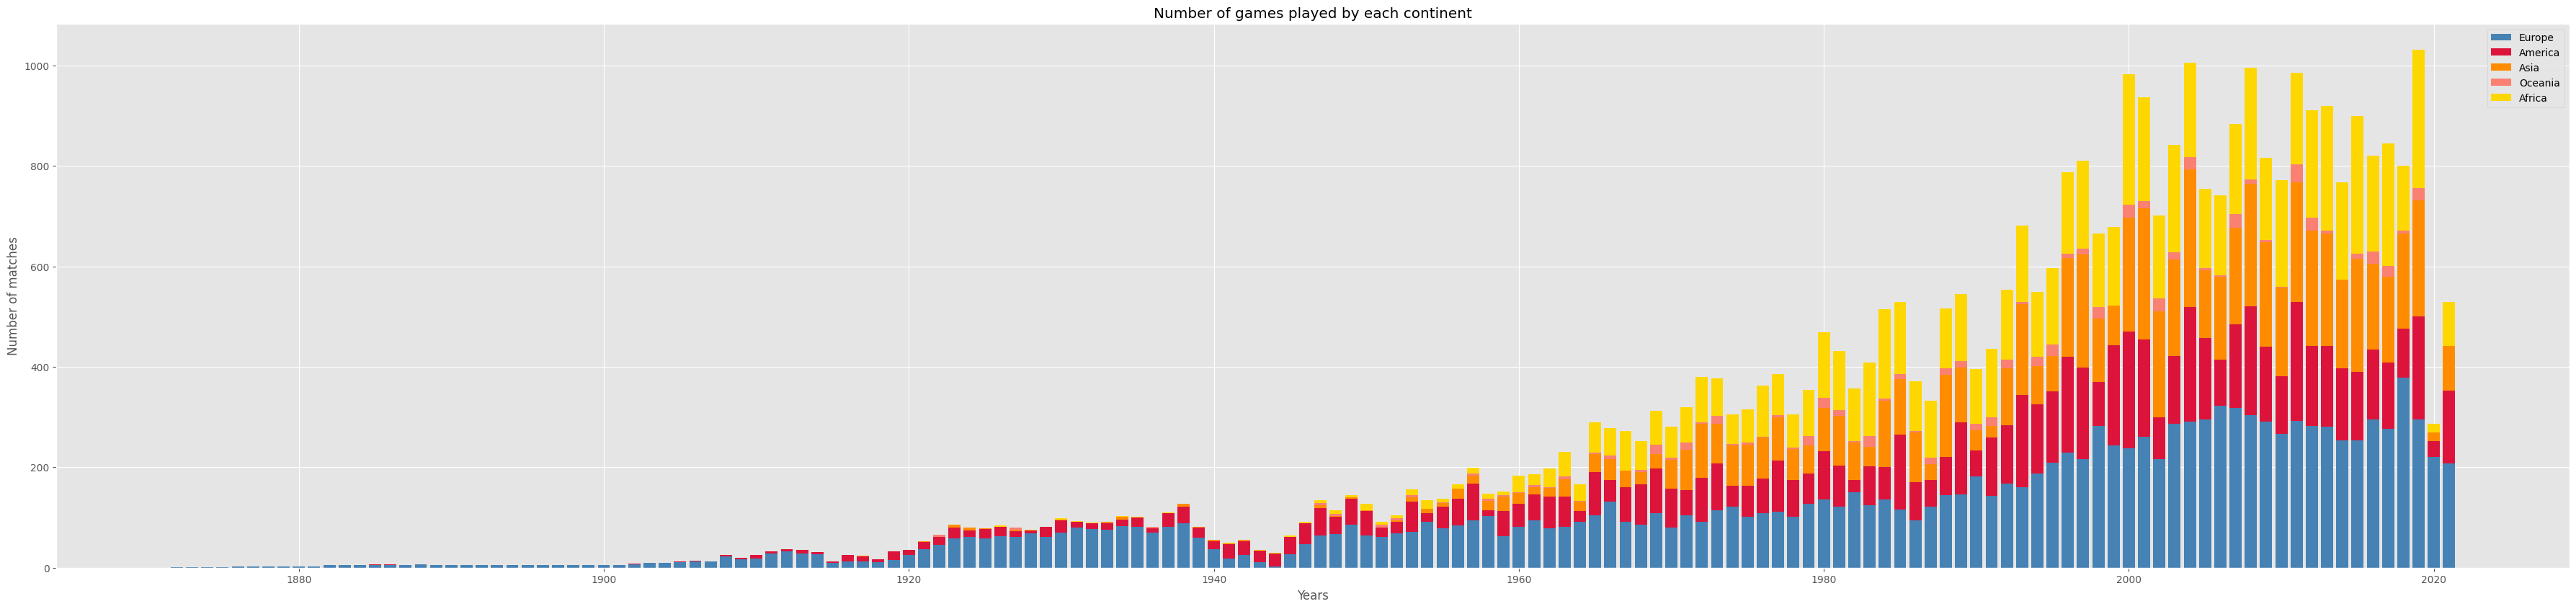

In [29]:
plt.title('Number of games played by each continent')
plt.ylabel('Number of matches')
plt.xlabel('Years')
plt.bar(years, europe.matches.values, color='steelblue')
plt.bar(years, america.matches.values, bottom=europe.matches.values , color='crimson')
plt.bar(years, asia.matches.values, bottom = europe.matches.values+america.matches.values, color='darkorange')
plt.bar(years, oceania.matches.values, bottom = europe.matches.values+america.matches.values+asia.matches.values , color='salmon')
plt.bar(years, africa.matches.values, bottom=europe.matches.values + america.matches.values + asia.matches.values + oceania.matches.values, color='gold')
plt.legend(['Europe', 'America', 'Asia', 'Oceania', 'Africa'])

plt.show()

Dal grafico si evince che Europa ed America sono i continenti dove si sono disputato più partite. Il numero di partite disputate in oceania è irrilevante rispetto al numero degli altri continenti nonostante l'Africa abbia disputato la prima partita ufficiale per ultima. <br>
Salvo comunque il dataframe per eventuali utilizzi

In [30]:
df.to_csv(path.join(PATH_DST, "dataset_v2_continent.csv"))

### Performance of a team -- cumsum
Prima di procedere con l'elaborazione e il preprocessing del modello si realizza una funzione per visualizzare la somma cumulativa dei pareggi/vittorie/sconfitte di una squadra <b>....CONTINUA DESCRIZIONE</b>

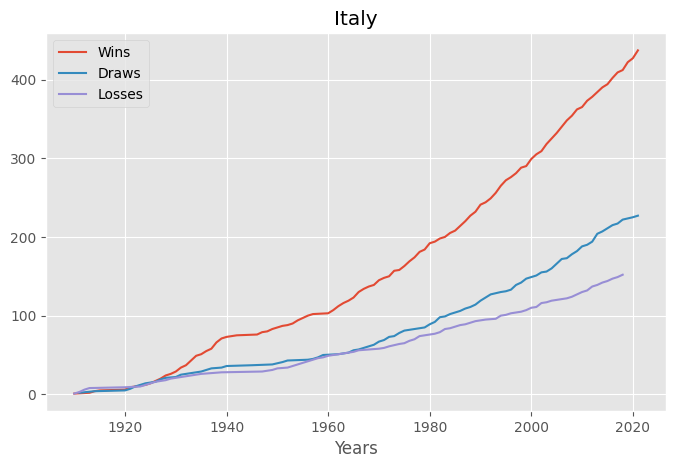

In [31]:
plt.rcParams.update({'figure.figsize':(8,5), 'figure.dpi':100})

cumsum_graph(df, 'Italy')

### Best teams during histories --- arrivato qui

<b>SCRIVI MEGLIO</b>
Prima di procedere con l'applicazione del modello si vuole trovare, se esiste, qualche correlazione tra le partite giocate fuori casa o no.<br>

Si vuole effettuare uno studio sulle nazioni che hanno:
- miglior attacco
- miglior difesa
- goal effettuati

Da queste si può risalire facilemente alle peggiori.<br>

- Inoltre si vuole verificare se esiste una correlazione tra:
- vi sono differenze il giocare in casa può influenzare l'esito del match
- se vi è propensione da parte di alcune squadre di vincere in casa o fuori

Si può calcolare adesso:

- Best attacking teams
- Best defence teams
- Best goal maker team

Estraggo un l'elenco dei team ed elimino quelli che non partecipano più alle competizioni  

sposta questa descrizione dopo ....
Estraggo un elenco dei teams dal dataset. Importo anche il dataset ranking FIFA, [disponibile a questo indirizzo su kaggle][https://www.kaggle.com/cashncarry/fifaworldranking?select=fifa_ranking-2021-05-27.csv], in modo da scartare i team presentanti nomi con nazioni non più presenti. Il dataset importanto contiene il rank delle squadre nazionali dal 1992. <b>scrivi meglio cosa vuoi dire</b>

In [8]:
df = pd.read_csv(path.join(PATH_DST, 'dataset_v1_valid_country.csv')).drop(columns=['Unnamed: 0'])
df_ = pd.read_csv(path.join(PATH_DST, 'dataset_v2_continent.csv')).drop(columns=['Unnamed: 0'])


In [9]:
# calcolo:
df['total_matches'] = 0

# CASE 1: neutral field
df['neutral_matches'] = 0
df['neutral_matches_wins'] = 0
df['neutral_matches_losses'] = 0
df['neutral_matches_draws'] = 0
df['neutral_matches_goal_scored'] = 0
df['neutral_matches_goal_conceded'] = 0

# CASE 2: play at home
df['home_matches'] = 0
df['home_matches_wins'] = 0
df['home_matches_losses'] = 0
df['home_matches_draws'] = 0
df['home_matches_goal_scored'] = 0
df['home_matches_goal_conceded'] = 0

# CASE 3: play in opponent's home
df['away_matches'] = 0
df['away_matches_wins'] = 0
df['away_matches_losses'] = 0
df['away_matches_draws'] = 0
df['away_matches_goal_scored'] = 0
df['away_matches_goal_conceded'] = 0


# nota: teoricamente dovrei considerarmi meno casi nella query ma dato che ho incertezza sulla correttezza del dataset li lascio per evitare di perdere dati
# dato che non cambia molto il tempo di esecuzione
for i in df.team:

    # CASE 1
    neutral_games = df_.query('neutral == True and home_team == @i or neutral == True and away_team == @i')

    df.at[df['team'] == i, 'neutral_matches'] = len(neutral_games)
    df.at[df['team'] == i, 'neutral_matches_wins'] = len( neutral_games.query('home_team == @i and outcome == "Home" or away_team == @i and outcome == "Away" ') )
    df.at[df['team'] == i, 'neutral_matches_losses'] = len( neutral_games.query('home_team == @i and outcome == "Away" or away_team == @i and outcome == "Home" ') )
    df.at[df['team'] == i, 'neutral_matches_draws'] = len(neutral_games.query('outcome == "Draw" ') )
    df.at[df['team'] == i, 'neutral_matches_goal_scored'] = neutral_games.query('home_team == @i')['home_score'].sum() + neutral_games.query('away_team == @i')['away_score'].sum()
    df.at[df['team'] == i, 'neutral_matches_goal_conceded'] = neutral_games.query('home_team != @i')['home_score'].sum() + neutral_games.query('away_team != @i')['away_score'].sum()


    # CASE 2: play at home (own country)
    home_games = df_.query('(neutral == False and country == @i) and ( home_team == @i or away_team == @i) ')
    
    df.at[df['team'] == i, 'home_matches'] = len(home_games)
    df.at[df['team'] == i, 'home_matches_wins'] = len(home_games.query('home_team == @i and outcome == "Home" or away_team == @i and outcome == "Away" ') )
    df.at[df['team'] == i, 'home_matches_losses'] = len(home_games.query('home_team == @i and outcome == "Away" or away_team == @i and outcome == "Home" ') )
    df.at[df['team'] == i, 'home_matches_draws'] = len(home_games.query('outcome == "Draw" ') )
    df.at[df['team'] == i, 'home_matches_goal_scored'] = home_games.query('home_team == @i')['home_score'].sum() + home_games.query('away_team == @i')['away_score'].sum()
    df.at[df['team'] == i, 'home_matches_goal_conceded'] = home_games.query('home_team != @i')['home_score'].sum() + home_games.query('away_team != @i')['away_score'].sum()


    # CASE 3: play in opponent's home
    away_games = df_.query('(neutral == False and country != @i) and (home_team == @i or away_team == @i) ')

    df.at[df['team'] == i, 'away_matches'] = len(away_games)
    df.at[df['team'] == i, 'away_matches_wins'] = len(away_games.query('home_team == @i and outcome == "Home" or away_team == @i and outcome == "Away" ') )
    df.at[df['team'] == i, 'away_matches_losses'] = len(away_games.query('home_team == @i and outcome == "Away" or away_team == @i and outcome == "Home" ') )
    df.at[df['team'] == i, 'away_matches_draws'] = len(away_games.query('outcome == "Draw" ') )
    df.at[df['team'] == i, 'away_matches_goal_scored'] = away_games.query('home_team == @i')['home_score'].sum() + away_games.query('away_team == @i')['away_score'].sum()
    df.at[df['team'] == i, 'away_matches_goal_conceded'] = away_games.query('home_team != @i')['home_score'].sum() + away_games.query('away_team != @i')['away_score'].sum()

    # calcolo  il numero totale dei match
    df.at[df['team'] == i, 'total_matches'] = len(neutral_games) + len(home_games) + len(away_games)

In [10]:
df.shape

(209, 21)

Vi è un totale di 209 squadre. Per prima cosa controllo il numero di partite medio per una squadra

In [11]:
df['total_matches'].describe()

count     209.000000
mean      373.483254
std       247.313315
min         7.000000
25%       174.000000
50%       336.000000
75%       537.000000
max      1030.000000
Name: total_matches, dtype: float64

Data la presenza di squadre che hanno disputato anche meno di 50 match, decido arbitrariamente di eliminarle dal dataset.

In [12]:
# elimino outliers
df = df.query('total_matches >= 100 & home_matches >= 100 & away_matches >= 0 & neutral_matches >= 0')
df.to_csv(path.join(PATH_DST, 'dataset_v2_teams_performance_detail.csv'))
df.shape

(113, 21)

Innanzitutto mi estrapolo:
- Squadra che ha partecipato di più alle competizioni
- Team più vincente
- Miglior attacco
- Miglior difesa
<br>
Estrarrò sempre le prime 10 migliori.

Inoltre per aiutarmi nella classificazione, assegno ad ogni squadra un colore diverso preso dalla libreria di matplotlib.<br>

In questo modo sarà più facile notare ripetizioni all'interno del grafico

In [13]:
colors = list(mcolors.CSS4_COLORS)
df['color'] = colors[:len(df)]

# aggiungo colonne dovute ai grafici che devo creare sotto
df['tot_wins'] = 0
df['tot_losses'] = 0
df['tot_draws'] = 0

# home win rate
df['home_win_rate'] = 0
# away win rate
df['away_win_rate'] = 0
# neutral win rate
df['neutral_win_rate'] = 0

df['tot_goal_scored'] = 0
df['tot_goal_conceded'] = 0

# goal per match
df['goal_scored_rate'] = 0
df['goal_conceded_rate'] = 0

for i in df.team.values:
    curr_team = df.query("team == @i")
    df.at[df['team'] == i, 'tot_wins'] = (curr_team['neutral_matches_wins'] + curr_team['home_matches_wins'] + curr_team['away_matches_wins']) / curr_team['total_matches'] * 100
    df.at[df['team'] == i, 'tot_losses'] = (curr_team['neutral_matches_losses'] + curr_team['home_matches_losses'] + curr_team['away_matches_losses']) / curr_team['total_matches'] * 100
    df.at[df['team'] == i, 'tot_draws'] = (curr_team['neutral_matches_draws'] + curr_team['home_matches_draws'] + curr_team['away_matches_draws']) / curr_team['total_matches'] * 100

    df.at[df['team'] == i, 'home_win_rate'] = curr_team['home_matches_wins'] / curr_team['home_matches'] * 100
    df.at[df['team'] == i, 'away_win_rate'] = curr_team['away_matches_wins'] / curr_team['away_matches'] * 100
    df.at[df['team'] == i, 'neutral_win_rate'] = curr_team['neutral_matches_wins'] / curr_team['neutral_matches'] * 100

    df.at[df['team'] == i, 'tot_goal_scored'] = curr_team['neutral_matches_goal_scored'] + curr_team['home_matches_goal_scored'] + curr_team['away_matches_goal_scored'] 
    df.at[df['team'] == i, 'tot_goal_conceded'] = curr_team['neutral_matches_goal_conceded'] + curr_team['home_matches_goal_conceded'] + curr_team['away_matches_goal_conceded']

    df.at[df['team'] == i, 'goal_scored_rate'] = df.loc[df['team'] == i]['tot_goal_scored'] / curr_team['total_matches']
    df.at[df['team'] == i, 'home_goal_scored_rate'] = curr_team['home_matches_goal_scored'] / curr_team['home_matches']
    df.at[df['team'] == i, 'away_goal_scored_rate'] = curr_team['home_matches_goal_scored'] / curr_team['away_matches']
    df.at[df['team'] == i, 'neutral_goal_scored_rate'] = curr_team['neutral_matches_goal_scored'] / curr_team['neutral_matches']

    df.at[df['team'] == i, 'goal_conceded_rate'] = df.loc[df['team'] == i]['tot_goal_conceded'] / curr_team['total_matches'] 
    df.at[df['team'] == i, 'home_goal_conceded_rate'] = curr_team['home_matches_goal_conceded'] / curr_team['home_matches']
    df.at[df['team'] == i, 'away_goal_conceded_rate'] = curr_team['home_matches_goal_conceded'] / curr_team['away_matches']
    df.at[df['team'] == i, 'neutral_goal_conceded_rate'] = curr_team['neutral_matches_goal_conceded'] / curr_team['neutral_matches']

df.to_csv(path.join(PATH_DST, 'dataset_v2_teams_performance_detail_percentage.csv'))

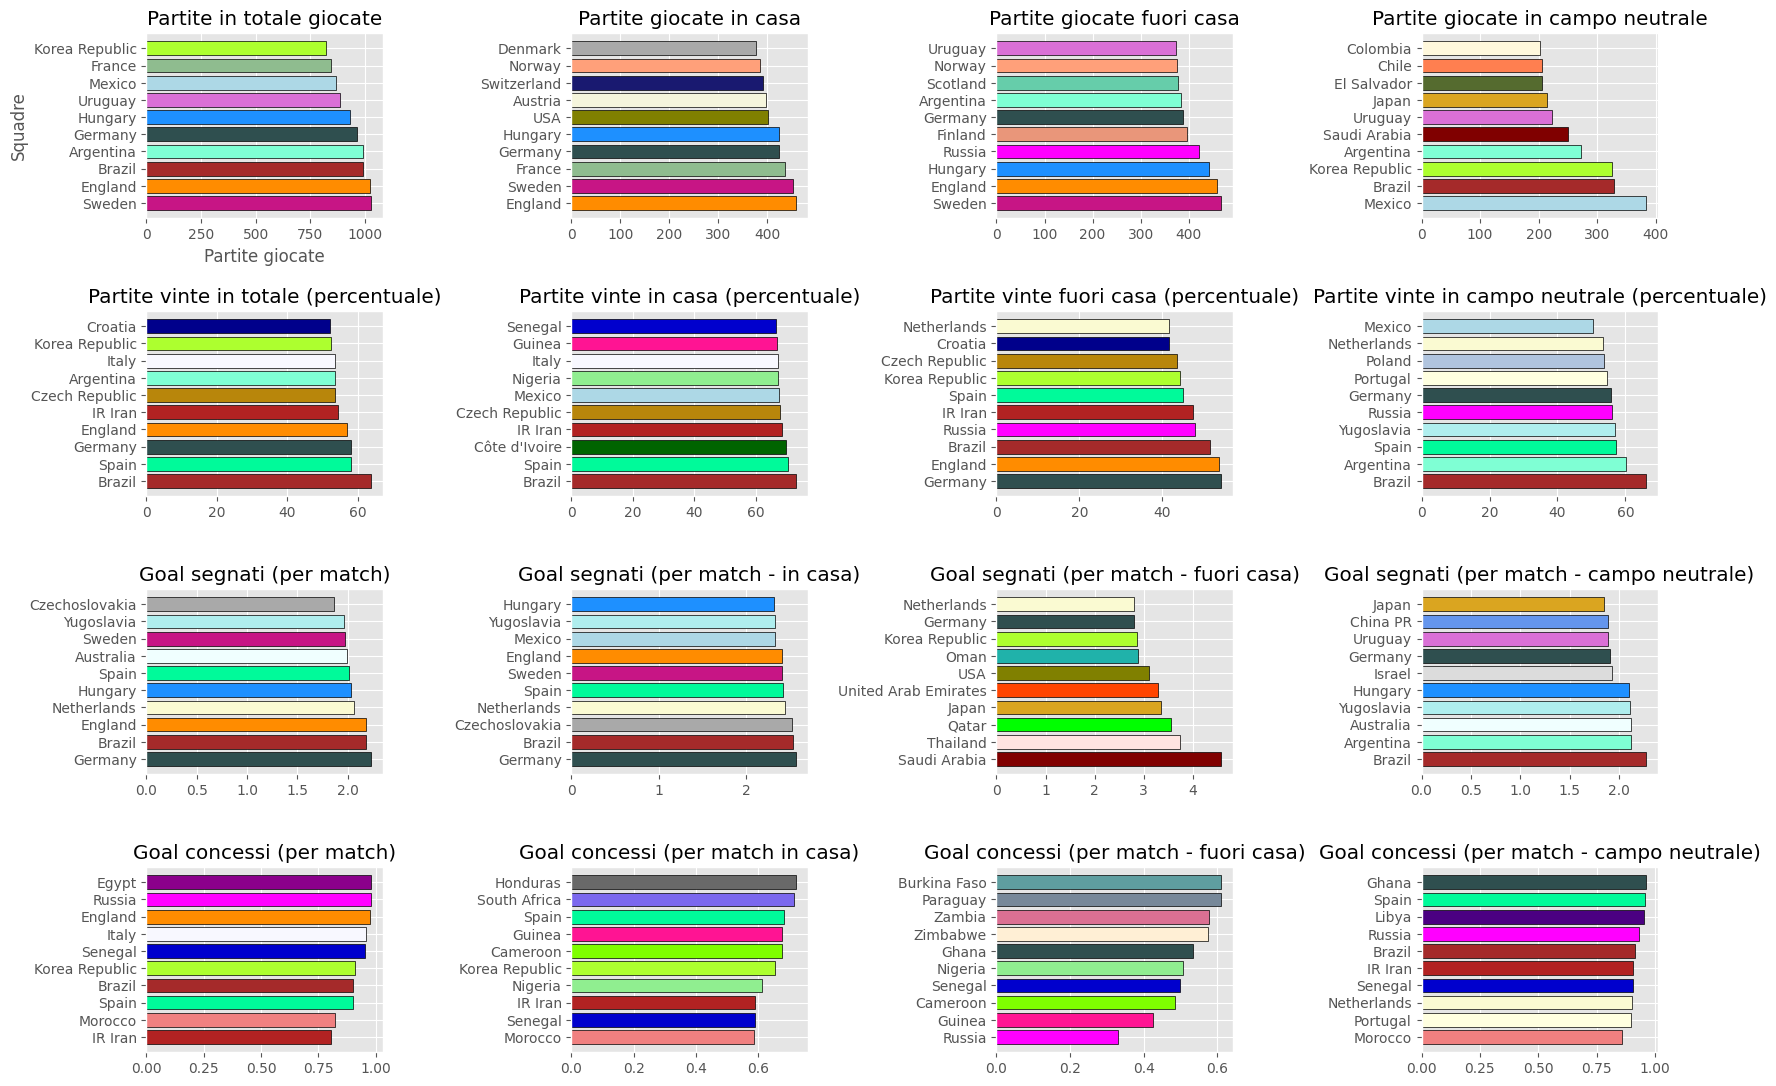

In [14]:
plt.rcParams.update({'figure.figsize':(45,10), 'figure.dpi':100})

fig, axs = plt.subplots(4, 4)

fig.set_size_inches(19.5, 13.5)
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.8, hspace=0.5)

# -------- squadra che ha giocato di più ----------
df = df.sort_values(by=['total_matches'], ascending=False)
axs[0, 0].set_title('Partite in totale giocate')
axs[0, 0].set_ylabel('Squadre')
axs[0, 0].set_xlabel('Partite giocate')
axs[0, 0].barh(df.team.values[:10], df.total_matches.values[:10], color=df.color.values[:10], edgecolor='black')

# .. in casa
df = df.sort_values(by=['home_matches'], ascending=False)
axs[0, 1].set_title('Partite giocate in casa')
axs[0, 1].barh(df.team.values[:10], df.home_matches.values[:10], color=df.color.values[:10], edgecolor='black')

# .. fuori casa
df = df.sort_values(by=['away_matches'], ascending=False)
axs[0, 2].set_title('Partite giocate fuori casa')
axs[0, 2].barh(df.team.values[:10], df.away_matches.values[:10], color=df.color.values[:10], edgecolor='black')

# .. campo neutrale
df = df.sort_values(by=['neutral_matches'], ascending=False)
axs[0, 3].set_title('Partite giocate in campo neutrale')
axs[0, 3].barh(df.team.values[:10], df.neutral_matches.values[:10], color=df.color.values[:10], edgecolor='black')


# --------- squadra che ha vinto di più -----------
df = df.sort_values(by=['tot_wins'], ascending=False)
axs[1, 0].set_title('Partite vinte in totale (percentuale)')
axs[1, 0].barh(df.team.values[:10], df.tot_wins.values[:10], color=df.color.values[:10], edgecolor='black')

# .. in casa
df = df.sort_values(by=['home_win_rate'], ascending=False)
axs[1, 1].set_title('Partite vinte in casa (percentuale)')
axs[1, 1].barh(df.team.values[:10], df.home_win_rate.values[:10], color=df.color.values[:10], edgecolor='black')

# .. fuori casa
df = df.sort_values(by=['away_win_rate'], ascending=False)
axs[1, 2].set_title('Partite vinte fuori casa (percentuale)')
axs[1, 2].barh(df.team.values[:10], df.away_win_rate.values[:10], color=df.color.values[:10], edgecolor='black')

# .. campo neutrale
df = df.sort_values(by=['neutral_win_rate'], ascending=False)
axs[1, 3].set_title('Partite vinte in campo neutrale (percentuale)')
axs[1, 3].barh(df.team.values[:10], df.neutral_win_rate.values[:10], color=df.color.values[:10], edgecolor='black')

# -------------- miglior attacco -------------- 
df = df.sort_values(by=['goal_scored_rate'], ascending=False)
axs[2, 0].set_title('Goal segnati (per match)')
axs[2, 0].barh(df.team.values[:10], df.goal_scored_rate.values[:10], color=df.color.values[:10], edgecolor='black')

# .. in casa
df = df.sort_values(by=['home_goal_scored_rate'], ascending=False)
axs[2, 1].set_title('Goal segnati (per match - in casa)')
axs[2, 1].barh(df.team.values[:10], df.home_goal_scored_rate.values[:10], color=df.color.values[:10], edgecolor='black')

# .. fuori casa
df = df.sort_values(by=['away_goal_scored_rate'], ascending=False)
axs[2, 2].set_title('Goal segnati (per match - fuori casa)')
axs[2, 2].barh(df.team.values[:10], df.away_goal_scored_rate.values[:10], color=df.color.values[:10], edgecolor='black')

# .. campo neutrale
df = df.sort_values(by=['neutral_goal_scored_rate'], ascending=False)
axs[2, 3].set_title('Goal segnati (per match - campo neutrale)')
axs[2, 3].barh(df.team.values[:10], df.neutral_goal_scored_rate.values[:10], color=df.color.values[:10], edgecolor='black')


# -------------- miglior difesa -------------- 
df = df.sort_values(by=['goal_conceded_rate'], ascending=True)
axs[3, 0].set_title('Goal concessi (per match)')
axs[3, 0].barh(df.team.values[:10], df.goal_conceded_rate.values[:10], color=df.color.values[:10], edgecolor='black')

# .. in casa
df = df.sort_values(by=['home_goal_conceded_rate'], ascending=True)
axs[3, 1].set_title('Goal concessi (per match in casa)')
axs[3, 1].barh(df.team.values[:10], df.home_goal_conceded_rate.values[:10], color=df.color.values[:10], edgecolor='black')

# .. fuori casa
df = df.sort_values(by=['away_goal_conceded_rate'], ascending=True)
axs[3, 2].set_title('Goal concessi (per match - fuori casa)')
axs[3, 2].barh(df.team.values[:10], df.away_goal_conceded_rate.values[:10], color=df.color.values[:10], edgecolor='black')

# .. campo neutrale
df = df.sort_values(by=['neutral_goal_conceded_rate'], ascending=True)
axs[3, 3].set_title('Goal concessi (per match - campo neutrale)')
axs[3, 3].barh(df.team.values[:10], df.neutral_goal_conceded_rate.values[:10], color=df.color.values[:10], edgecolor='black')

plt.show()

Inserisci considerazioni ........

## Parte 3: Proposta del modello ed implementazione

In [37]:
# posso prendere anche quello con continent, non cambia nulla a livello di informazione c'è solo una colonna in +
# così mi vedo l'influenza del continente
df = pd.read_csv(path.join(PATH_DST, 'dataset_v2_continent.csv')).drop(columns=['Unnamed: 0'])
# per avere inizialmente i calcoli leggeri ed occupare poca memoria
# df = df.query("year >= 2000")
df

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral,outcome,year,continent
0,1872-11-30,Scotland,England,0.0,0.0,Friendly,Glasgow,Scotland,False,Draw,1872,Europe
1,1873-03-08,England,Scotland,4.0,2.0,Friendly,London,England,False,Home,1873,Europe
2,1874-03-07,Scotland,England,2.0,1.0,Friendly,Glasgow,Scotland,False,Home,1874,Europe
3,1875-03-06,England,Scotland,2.0,2.0,Friendly,London,England,False,Draw,1875,Europe
4,1876-03-04,Scotland,England,3.0,0.0,Friendly,Glasgow,Scotland,False,Home,1876,Europe
...,...,...,...,...,...,...,...,...,...,...,...,...
39024,2021-07-25,Costa Rica,Canada,0.0,2.0,Gold Cup,Arlington,USA,True,Away,2021,America
39025,2021-07-25,USA,Jamaica,1.0,0.0,Gold Cup,Arlington,USA,False,Home,2021,America
39026,2021-07-29,Mexico,Canada,2.0,1.0,Gold Cup,Houston,USA,True,Home,2021,America
39027,2021-07-29,USA,Qatar,1.0,0.0,Gold Cup,Austin,USA,False,Home,2021,America


In [19]:
# per farmi ritornare il nome successivamente.. non so se devi tenere
outcome_dict = {1.0: "Home", 0.0: "Draw", 2: "Away"}


'Home'

In [24]:
df.columns

Index(['date', 'home_team', 'away_team', 'home_score', 'away_score',
       'tournament', 'city', 'country', 'neutral', 'outcome', 'year',
       'continent'],
      dtype='object')

Label encoding

In [31]:
len(df['home_team'].drop_duplicates())

207

In [33]:
len(df['away_team'].drop_duplicates())

206

In [35]:
df['away_team'].sort_values().values

array(['Afghanistan', 'Afghanistan', 'Afghanistan', ..., 'Zimbabwe',
       'Zimbabwe', 'Zimbabwe'], dtype=object)

In [39]:
list(set(df['home_team'].drop_duplicates().sort_values().values).difference(df['away_team'].drop_duplicates().sort_values().values))

['St. Kitts and Nevis']

In [ ]:
# devo iniziare ad effettuare alcune modifiche al dataset per renderlo adatto al modello
df['neutral'] = df['neutral'].astype(float)

# outcome:
#   1 home team win 
#   0 draw
#   2 away team win
df['outcome'] = df['outcome'].replace({"Home": 1.0, "Draw": 0, "Away": 2})

# elimino gli spazi dal dataset
df['home_team'] = df['home_team'].str.replace(" ", "_")
df['away_team'] = df['away_team'].str.replace(" ", "_")
df['tournament'] = df['tournament'].str.replace(" ", "_")
# non so se presente lo spazio ma modifico comunque
df['country'] = df['country'].str.replace(" ", "_")
df['city'] = df['city'].str.replace(" ", "_")

# Prepare DF to label encoding for home_team and away_team
df_ht = df['home_team'].drop_duplicates().sort_values().reset_index().drop(labels=['index'], axis=1)
df_at = df['away_team'].drop_duplicates().sort_values().reset_index().drop(labels=['index'], axis=1)
df_ht = df_ht.rename(columns={'home_team': 'team'})
df_at = df_at.rename(columns={'away_team': 'team'})
teams = pd.concat([df_ht,df_at]).drop_duplicates().sort_values(by='team').reset_index().drop(labels=['index'], axis=1)
label_encoder = preprocessing.LabelEncoder()
teams['label'] = label_encoder.fit_transform(teams['team'])

# Tournaments label encoding
df_tournament = df['tournament'].drop_duplicates().sort_values().reset_index().drop(labels=['index'], axis=1)
df_tournament['label'] = label_encoder.fit_transform(df_tournament['tournament'])

for i, row in df.iterrows():
	# print(f"Index: {i}")
	# print(f"{row}\n")
    ht = row.home_team
    at = row.away_team
    tournament = row.tournament

    df.at[i, 'home_team'] = teams.query("team == @ht")["label"].values.astype(float)[0]
    df.at[i, 'away_team'] = teams.query("team == @at")["label"].values.astype(float)[0]
    df.at[i, 'tournament'] = df_tournament.query("tournament == @tournament")["label"].values.astype(float)[0]


df['home_team'] = df['home_team'].astype(float)
df['away_team'] = df['away_team'].astype(float)
df['tournament'] = df['tournament'].astype(float)

df.to_csv(path.join(PATH_DST, 'dataset_for_model.csv'))

df_tournament.to_csv("tournament_output.csv")
teams.to_csv("teams_output.csv")

#### -- correlazione tra var -- REDO WITH NEW VARIABLES

In [165]:
# indice di correlazione di pearson per quantificare la correlazione tra due variabili con df.corr
# per ottenere un indice invariante rispetto a quanto i valori delle variabili siano dispersi si può applicare lo z-score alle due variabili indipendentemente prima di calcolare le covarianze.

corr_index, p_value = pearsonr(df['neutral'],df['outcome'])

# indice_corr, p-value

print(corr_index, "{:.2f}".format(p_value))

# l'indice ci ritorna una correlazione debole positiva. il p value vicino a 0 indica che tale correlazione è statisticamente rilevante
# tale indice funziona solo se la relazione tra le variabili è lineare e se le variabili sono distribuite in maniera normale. dati i molti outliers utilizziamo quello di spearman

corr_index, p_value = spearmanr(df['neutral'],df['outcome'])
print(corr_index, "{:.2f}".format(p_value))

# kendall : inserisci descr...

corr_index, p_value = kendalltau(df['neutral'],df['outcome'])
print(corr_index, "{:.2f}".format(p_value))

# ......

corr_index, p_value = spearmanr(df['home_team'],df['outcome'])
print(corr_index, "{:.2f}".format(p_value))

corr_index, p_value = spearmanr(df['away_team'],df['outcome'])
print(corr_index, "{:.2f}".format(p_value))

0.03484310876984703 0.00
0.03687270094353973 0.00
0.03494507997370449 0.00
-0.010766730737996026 0.27
-0.0008983628723594811 0.93


In [166]:
df.corr()

,home_team,away_team,home_score,away_score,tournament,neutral,outcome
home_team,1.000000,-0.002186,0.011274,-0.012058,-0.020904,-0.016593,-0.010436
away_team,-0.002186,1.000000,-0.015998,0.007543,-0.008075,0.027746,-0.000798
home_score,0.011274,-0.015998,1.000000,-0.179757,0.003969,-0.043725,-0.115410
away_score,-0.012058,0.007543,-0.179757,1.000000,0.027069,0.101907,0.467443
tournament,-0.020904,-0.008075,0.003969,0.027069,1.000000,-0.137262,0.029016
neutral,-0.016593,0.027746,-0.043725,0.101907,-0.137262,1.000000,0.034843
outcome,-0.010436,-0.000798,-0.115410,0.467443,0.029016,0.034843,1.000000


<AxesSubplot:>

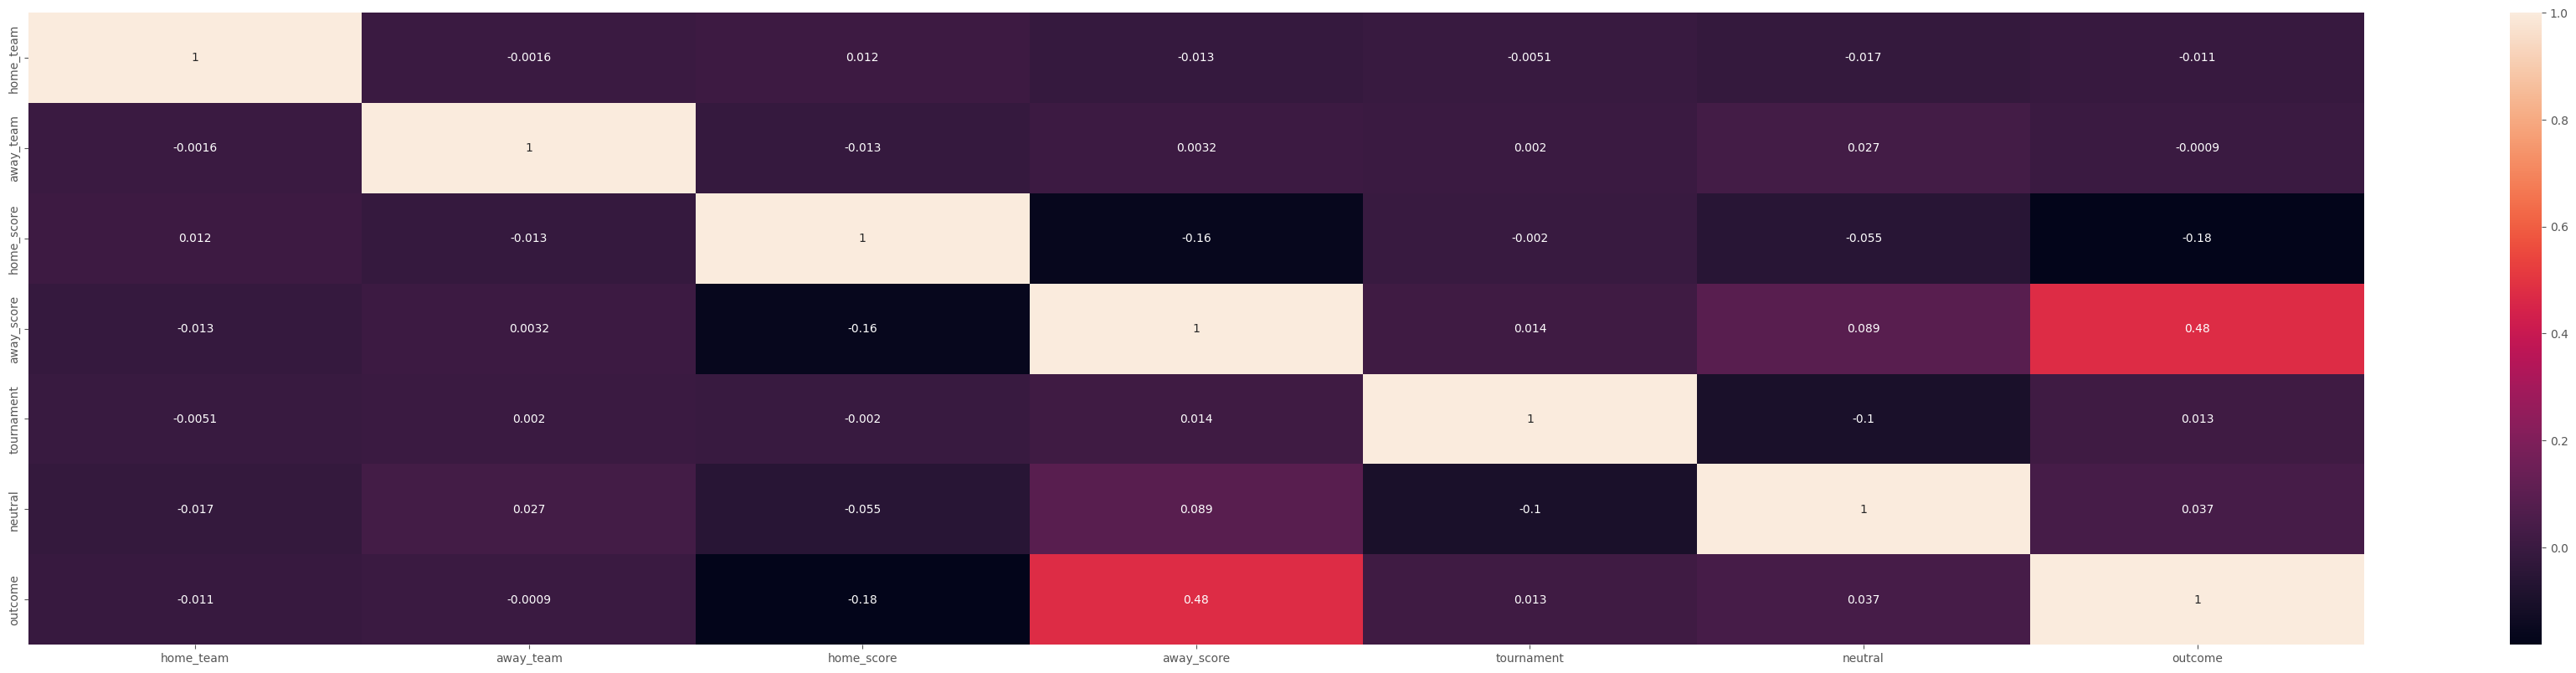

In [167]:
sns.heatmap(df.corr(method='spearman'), annot=True)

plt.show()

- Correlazione moderata tra away_score e risultato
- Correlazione debole tra neutral_field e away_score
- Anticorrelazione debole tra campo neutral e home_score
- Correlazione debole tra neutral e risultato

#### -----

Le variabili home_team e away_team sono categoriche. Per incluedere home_team e away_team tra le variabili per la regressione lineare devono essere trasformate in un insieme di variabili "dummy". Ogni variabile indicherà per ogni osservazione, se essa appartiene a una specifica classe tra quelle della variabile categorica considerata

In [3]:
df = pd.read_csv(path.join(PATH_DST, 'dataset_for_model.csv'))

X = df[['home_team','away_team','tournament','neutral']]
y = df[['home_score','away_score']]


In [4]:
regr = linear_model.LinearRegression()
regr.fit(X,y)

LinearRegression()

In [18]:
prediction = regr.predict([[127,292,1,1.0]])

print(prediction)

[[1.443688   1.22922873]]


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


In [8]:
df

,Unnamed: 0,date,home_team,away_team,home_score,away_score,tournament,neutral,outcome
0,31908,2010-01-02,118.0,137.0,1.0,0.0,32.0,1.0,1.0
1,31909,2010-01-02,206.0,159.0,0.0,0.0,32.0,0.0,0.0
2,31910,2010-01-02,249.0,291.0,6.0,0.0,32.0,1.0,1.0
3,31911,2010-01-02,286.0,255.0,0.0,1.0,32.0,0.0,2.0
4,31912,2010-01-03,8.0,96.0,1.0,1.0,32.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...
10570,42478,2021-07-25,62.0,46.0,0.0,2.0,33.0,1.0,2.0
10571,42479,2021-07-25,270.0,128.0,1.0,0.0,33.0,0.0,1.0
10572,42480,2021-07-29,167.0,46.0,2.0,1.0,33.0,1.0,1.0
10573,42481,2021-07-29,270.0,206.0,1.0,0.0,33.0,0.0,1.0


In [4]:
df.head(1)

,Unnamed: 0,date,home_team,away_team,home_score,away_score,tournament,neutral,outcome
0,31908,2010-01-02,118.0,137.0,1.0,0.0,32.0,1.0,1.0


In [3]:
model = ols(""" outcome ~ home_team + away_team + neutral + tournament """,df).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                outcome   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     6.525
Date:                Thu, 28 Oct 2021   Prob (F-statistic):           3.06e-05
Time:                        15:51:02   Log-Likelihood:                -11538.
No. Observations:               10575   AIC:                         2.309e+04
Df Residuals:                   10570   BIC:                         2.312e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.9924      0.025     39.028      0.000       0.943       1.042
home_team  -7.915e-05   8.48e-05     -0.933      0.351      -0.000    8.71e-05
away_team  -1.428e-05   8.49e-05     -0.168      0.866      -0.000       0.000
neutral        0.0625      0.016      4.019      0.000       0.032       0.093
tournament     0.0019      0.001      3.489      0.000       0.001       0.003
==============================================================================
Omnibus:                     3561.009   Durbin-Watson:                   1.987
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              516.497
Skew:                          -0.089   Prob(JB):                    6.99e-113
Kurtosis:                       1.932   Cond. No.                         820.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [4]:
feature = np.array([[118, 137, 1, 1]])
prediction =  model.predict(feature)

In [ ]:
prediction